In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [38]:
# Load Data
train_data = pd.read_csv("./KDDTrain+.txt")
test_data = pd.read_csv("./KDDTest+.txt")

In [39]:
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'attack', 'level']

In [40]:
train_data.columns = columns
test_data.columns = columns

In [41]:
full_data = pd.concat([train_data, test_data], ignore_index=True)

In [42]:
# Encode categorical features
label_encoders = {}
for column in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    full_data[column] = le.fit_transform(full_data[column])
    label_encoders[column] = le

In [43]:
# Binary classification: normal vs. attack
full_data['attack'] = full_data['attack'].apply(lambda x: 1 if x != 'normal' else 0)

X = full_data.drop(['attack', 'level'], axis=1)
y = full_data['attack']

In [44]:
# Feature Selection with RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=30)
rfe.fit(X, y)
X_rfe_selected = X[X.columns[rfe.support_]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfe_selected)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to categorical (optional for multi-class, keep as is for binary classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [45]:
# Mutual Information for Feature Filtering
mi_scores = mutual_info_classif(X_rfe_selected, y, random_state=42)
mi_threshold = np.percentile(mi_scores, 20)
final_selected_features = X_rfe_selected.columns[mi_scores > mi_threshold]
X_final = X_rfe_selected[final_selected_features]

In [46]:
print("Mutual Information Threshold (30th percentile):", mi_threshold)

Mutual Information Threshold (30th percentile): 0.04811472506362304


In [47]:
mi_scores = pd.Series(mi_scores, index=X_rfe_selected.columns)
mi_scores.sort_values(ascending=False)

src_bytes                      0.541850
dst_bytes                      0.437241
service                        0.432429
flag                           0.336884
same_srv_rate                  0.327828
diff_srv_rate                  0.320930
dst_host_srv_count             0.303265
dst_host_same_srv_rate         0.278638
logged_in                      0.263778
dst_host_diff_srv_rate         0.258077
dst_host_serror_rate           0.239356
serror_rate                    0.234673
count                          0.233662
dst_host_srv_serror_rate       0.233028
srv_serror_rate                0.222280
dst_host_srv_diff_host_rate    0.170817
dst_host_count                 0.139148
dst_host_same_src_port_rate    0.128823
srv_diff_host_rate             0.095268
dst_host_srv_rerror_rate       0.064169
rerror_rate                    0.055468
protocol_type                  0.055387
dst_host_rerror_rate           0.054603
srv_count                      0.048194
srv_rerror_rate                0.047799


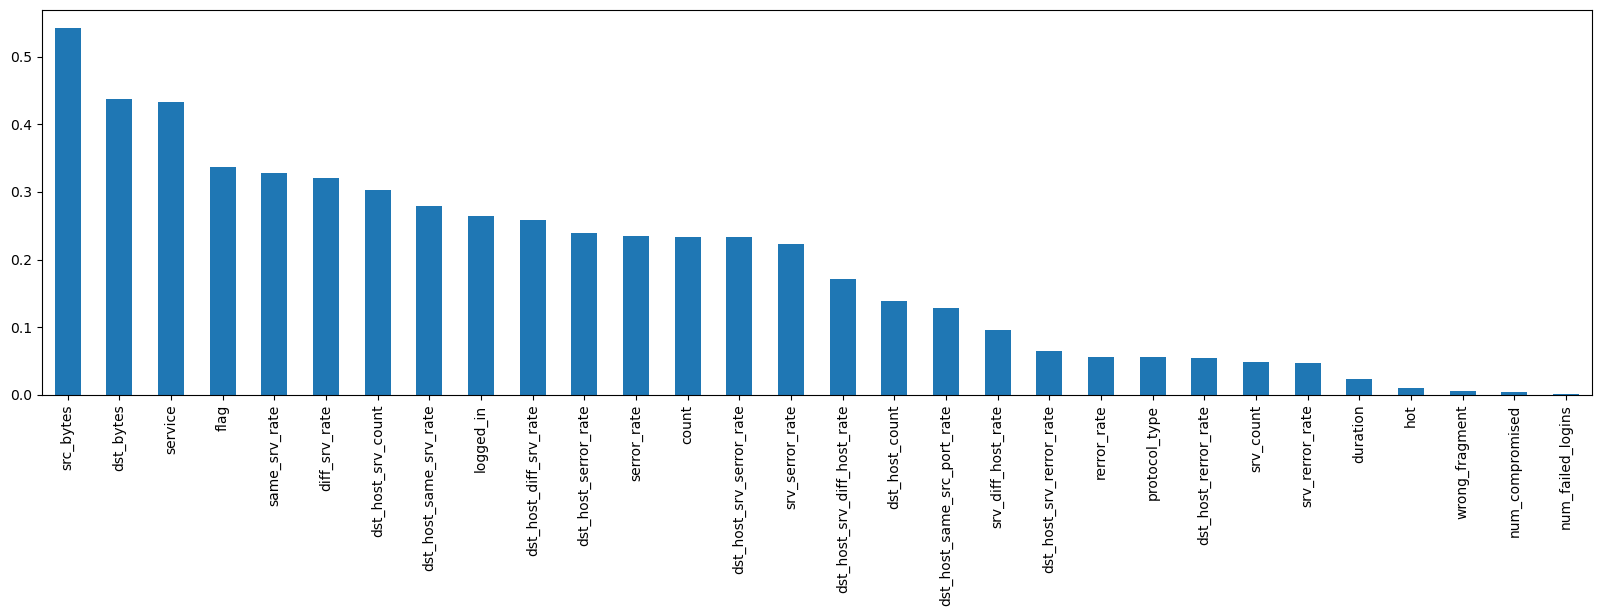

In [48]:
mi_scores.sort_values(ascending=False).plot.bar(figsize=(20, 5));

In [49]:
# Display the selected features
print("Selected Features after Mutual Information Filtering:")
print(final_selected_features.tolist())
print(f"\nNumber of Columns Retained: {len(final_selected_features)}")

Selected Features after Mutual Information Filtering:
['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

Number of Columns Retained: 24


In [50]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Change from 1 neuron (sigmoid) to 2 neurons (softmax)
])

# Compile the model with categorical loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/20
1857/1857 [==============================] - 9s 3ms/step - loss: 0.1072 - accuracy: 0.9603 - val_loss: 0.0637 - val_accuracy: 0.9752
Epoch 2/20
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0636 - accuracy: 0.9761 - val_loss: 0.0542 - val_accuracy: 0.9800
Epoch 3/20
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0563 - accuracy: 0.9789 - val_loss: 0.0486 - val_accuracy: 0.9811
Epoch 4/20
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0515 - accuracy: 0.9805 - val_loss: 0.0451 - val_accuracy: 0.9831
Epoch 5/20
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0481 - accuracy: 0.9817 - val_loss: 0.0433 - val_accuracy: 0.9835
Epoch 6/20
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0456 - accuracy: 0.9827 - val_loss: 0.0409 - val_accuracy: 0.9847
Epoch 7/20
1857/1857 [==============================] - 5s 3ms/step - loss: 0.0437 - accuracy: 0.9830 - val_loss: 0.0400 - val_accuracy:

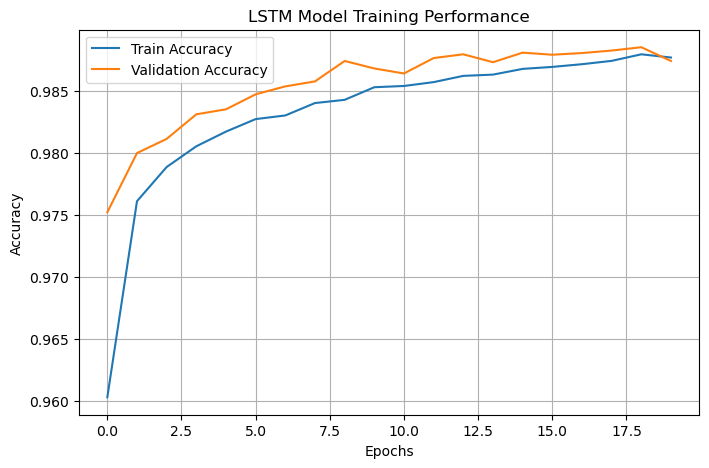

In [52]:
# Plot Training Loss & Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title("LSTM Model Training Performance")
plt.show()

In [53]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Convert y_test back to labels
y_test_labels = np.argmax(y_test, axis=1)

929/929 [==============================] - 2s 2ms/step


In [54]:
# Convert one-hot encoded labels to single-class labels
y_test_labels = np.argmax(y_test, axis=1)  # Convert test labels to class index
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class index

# Now use classification metrics
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))


Confusion Matrix:
 [[15297   114]
 [  259 14033]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     15411
           1       0.99      0.98      0.99     14292

    accuracy                           0.99     29703
   macro avg       0.99      0.99      0.99     29703
weighted avg       0.99      0.99      0.99     29703



In [55]:
# Standardize Data
scaler = StandardScaler()
X_final = scaler.fit_transform(X_final)

In [56]:
from sklearn.model_selection import StratifiedKFold
# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

X_final_np = X_final

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

kf = KFold(n_splits=5, shuffle=True, random_state=42)
num_classes = len(np.unique(y))  # Get number of classes

fold_accuracies, fold_precisions, fold_recalls, fold_f1s = [], [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_final_np, y), 1):
    X_train, X_test = X_final_np[train_index], X_final_np[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ensure at least two classes are present in training data
    if len(np.unique(y_train)) < 2:
        print(f"Skipping Fold {fold} (Only one class in training data)")
        continue
    
    # Reshape input for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    # One-hot encode labels only for multi-class classification
    if num_classes > 2:
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))
    model.add(Dense(25, activation='relu'))
    
    if num_classes > 2:
        model.add(Dense(num_classes, activation='softmax'))
        loss_function = 'categorical_crossentropy'
    else:
        model.add(Dense(1, activation='sigmoid'))
        loss_function = 'binary_crossentropy'
    
    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1) if num_classes > 2 else (y_pred > 0.5).astype(int)
    y_test_classes = np.argmax(y_test, axis=1) if num_classes > 2 else y_test.astype(int)
    
    # Compute metrics
    acc = accuracy_score(y_test_classes, y_pred_classes)
    prec = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
    rec = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
    
    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)
    
    print(f"Fold {fold}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_classes, y_pred_classes))
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes))
    print("-" * 50)

929/929 [==============================] - 2s 2ms/step
Fold 1:
Confusion Matrix:
[[15160   197]
 [  192 14154]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15357
           1       0.99      0.99      0.99     14346

    accuracy                           0.99     29703
   macro avg       0.99      0.99      0.99     29703
weighted avg       0.99      0.99      0.99     29703

--------------------------------------------------
929/929 [==============================] - 2s 2ms/step
Fold 2:
Confusion Matrix:
[[15203   157]
 [  270 14073]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15360
           1       0.99      0.98      0.99     14343

    accuracy                           0.99     29703
   macro avg       0.99      0.99      0.99     29703
weighted avg       0.99      0.99      0.99     29703

-------------------------

In [60]:
for fold, (train_index, test_index) in enumerate(kf.split(X_final_np, y), 1):
    X_train, X_test = X_final_np[train_index], X_final_np[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    if len(np.unique(y_train)) < 2:
        print(f"Skipping Fold {fold} (Only one class in training data)")
        continue

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)  # Avoid division by zero
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)

    print(f"Fold {fold}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1:
Confusion Matrix:
[[14656   701]
 [ 1425 12921]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     15357
           1       0.95      0.90      0.92     14346

    accuracy                           0.93     29703
   macro avg       0.93      0.93      0.93     29703
weighted avg       0.93      0.93      0.93     29703

--------------------------------------------------


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2:
Confusion Matrix:
[[14675   685]
 [ 1463 12880]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     15360
           1       0.95      0.90      0.92     14343

    accuracy                           0.93     29703
   macro avg       0.93      0.93      0.93     29703
weighted avg       0.93      0.93      0.93     29703

--------------------------------------------------
Fold 3:
Confusion Matrix:
[[14720   596]
 [ 1599 12788]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     15316
           1       0.96      0.89      0.92     14387

    accuracy                           0.93     29703
   macro avg       0.93      0.92      0.93     29703
weighted avg       0.93      0.93      0.93     29703

--------------------------------------------------


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4:
Confusion Matrix:
[[15037   658]
 [ 1469 12539]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     15695
           1       0.95      0.90      0.92     14008

    accuracy                           0.93     29703
   macro avg       0.93      0.93      0.93     29703
weighted avg       0.93      0.93      0.93     29703

--------------------------------------------------
Fold 5:
Confusion Matrix:
[[14620   705]
 [ 1535 12843]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     15325
           1       0.95      0.89      0.92     14378

    accuracy                           0.92     29703
   macro avg       0.93      0.92      0.92     29703
weighted avg       0.93      0.92      0.92     29703

--------------------------------------------------


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Average Accuracy: 0.9269
Average Precision: 0.9502
Average Recall: 0.8950
Average F1-score: 0.9218


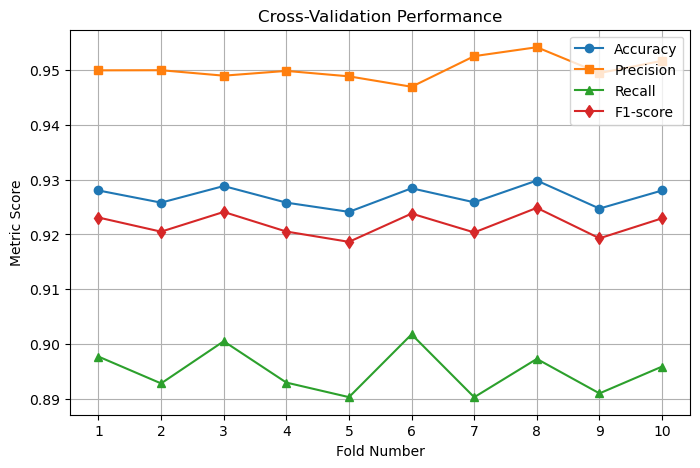

In [24]:
if fold_accuracies:
    avg_acc = np.mean(fold_accuracies)
    avg_prec = np.mean(fold_precisions)
    avg_rec = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1s)

    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Precision: {avg_prec:.4f}")
    print(f"Average Recall: {avg_rec:.4f}")
    print(f"Average F1-score: {avg_f1:.4f}")

    #Plot performance across folds
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', label='Accuracy')
    plt.plot(range(1, len(fold_precisions) + 1), fold_precisions, marker='s', label='Precision')
    plt.plot(range(1, len(fold_recalls) + 1), fold_recalls, marker='^', label='Recall')
    plt.plot(range(1, len(fold_f1s) + 1), fold_f1s, marker='d', label='F1-score')

    plt.xticks(range(1, len(fold_accuracies) + 1))
    plt.xlabel('Fold Number')
    plt.ylabel('Metric Score')
    plt.title('Cross-Validation Performance')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No valid folds with both classes. Check dataset balance.")

In [25]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_final, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

print("Training Scores (Mean):", train_mean)
print("Validation Scores (Mean):", val_mean)


c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Training Scores (Mean): [0.94727717 0.94736133 0.94665432 0.94767696 0.94657779 0.94628474
 0.94549105 0.94622774 0.93313944 0.92850049]
Validation Scores (Mean): [0.91928761 0.91903175 0.91875568 0.91927415 0.91862101 0.91836515
 0.91767835 0.91798135 0.91698482 0.91593442]


In [26]:
import pandas as pd
scores_df = pd.DataFrame({
    "Train Size": train_sizes,
    "Training Score": train_mean,
    "Validation Score": val_mean
})
print(scores_df)

   Train Size  Training Score  Validation Score
0       11881        0.947277          0.919288
1       23762        0.947361          0.919032
2       35643        0.946654          0.918756
3       47524        0.947677          0.919274
4       59406        0.946578          0.918621
5       71287        0.946285          0.918365
6       83168        0.945491          0.917678
7       95049        0.946228          0.917981
8      106930        0.933139          0.916985
9      118812        0.928500          0.915934


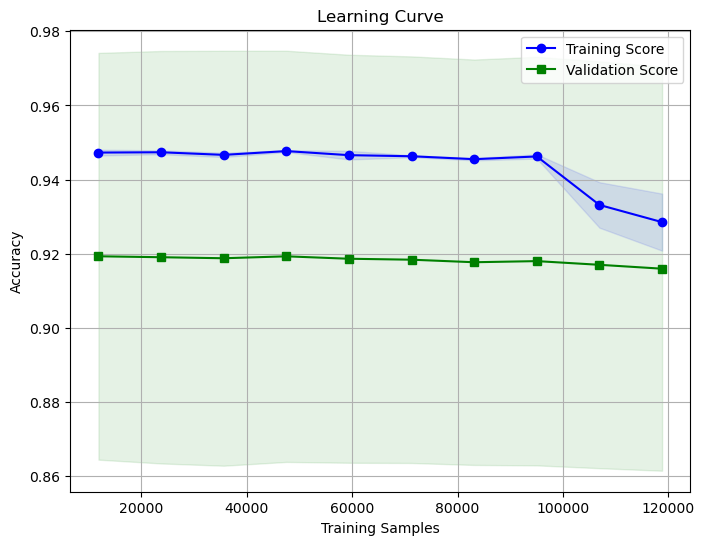

In [27]:
# Plot Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score", color="blue")
plt.plot(train_sizes, val_mean, 's-', label="Validation Score", color="green")

# Fill between to show standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

# Domain Adaptation Techniques

## 1. Introduction to Domain Adaptation
Domain adaptation is a technique used to improve model performance when training and test data come from different distributions. Key approaches include Transfer Learning and Adversarially Robust Intrusion Detection.

## 2. Transfer Learning for Domain Adaptation
Transfer learning leverages knowledge from a pre-trained model to adapt to a new task with limited data.

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0    

## 3. Adversarially Robust Intrusion Detection
Adversarial training enhances model robustness against adversarial attacks in cybersecurity applications.

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate synthetic adversarial data
x_train = np.random.rand(1000, 20)
y_train = np.random.randint(2, size=(1000, 1))

# Define a simple neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(20,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 0.6969 - accuracy: 0.5100
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5100
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5380
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.5500
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5520
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.5260
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.5720
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5680
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5760
Epoch 10/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5880


## 4. Accuracy Analysis
Performance evaluation using Precision, Recall, F1-score, and Confusion Matrix.

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate synthetic test data
x_test = np.random.rand(200, 20)
y_test = np.random.randint(2, size=(200, 1))
y_pred = (model.predict(x_test) > 0.5).astype(int)

# Compute accuracy metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

7/7 [==============================] - 0s 1ms/step
Accuracy: 0.505
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.49      0.52       109
           1       0.46      0.53      0.49        91

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.51       200

Confusion Matrix:
 [[53 56]
 [43 48]]


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Ensure `X_train` and `y_train` are properly formatted
X = np.array(X_train)
y = np.array(y_train)

# Ensure shape consistency
assert X.shape[0] == y.shape[0], f"Mismatch in X and y: X={X.shape}, y={y.shape}"

# K-Fold Cross-Validation with LSTM
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = (y.iloc[train_idx], y.iloc[val_idx]) if isinstance(y, pd.DataFrame) else (y[train_idx], y[val_idx])

    model = create_lstm_model((X_train_fold.shape[1], 1), y_train_fold.shape[1])
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    y_pred = np.argmax(model.predict(X_val_fold), axis=1)
    y_true = np.argmax(y_val_fold, axis=1)
    acc = accuracy_score(y_true, y_pred)
    print(f'Fold Accuracy: {acc:.4f}')


AssertionError: Mismatch in X and y: X=(133664, 24), y=(1000, 1)

In [ ]:

# Transfer Learning
from tensorflow.keras.models import load_model

# Load a pre-trained model (assuming an LSTM-based model is available)
pretrained_model = load_model('pretrained_lstm_model.h5')

# Fine-tune on new dataset
pretrained_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


In [ ]:

# Adversarially Robust Intrusion Detection
import tensorflow as tf

def adversarial_training(model, X_train, y_train, epsilon=0.1):
    X_train_adv = X_train + epsilon * np.sign(tf.gradients(model.total_loss, model.input)[0])
    X_train_adv = np.clip(X_train_adv, 0, 1)  # Ensure valid range
    model.fit(X_train_adv, y_train, epochs=5, batch_size=32)

adversarial_training(pretrained_model, X_train, y_train)
